In [1]:
import numpyro
import jax
numpyro.set_host_device_count(4)

import pandas as pd
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import tqdm

import bayesian_regression_models as brm

In [2]:
import scipy 
scipy.__version__

'1.16.0'

In [3]:
az.__version__

'0.18.0'

In [4]:
import narwhals as nw
nw.__version__

'1.21.1'

In [5]:
print(jax.__version__)
print(numpyro.__version__)

0.4.28
0.19.0


# Simulate data and fit

In [6]:

data_parameters = brm.data.gen_data_parameters()

#data_parameters["phi"] = data_parameters["phi"][1:5, :3]
#data_parameters["cluster_probabilities"] = data_parameters["cluster_probabilities"][:3] / data_parameters["cluster_probabilities"][:3].sum()

for idx in range(data_parameters["phi"].shape[1]):
    data_parameters["phi"][:, idx] = np.roll(data_parameters["phi"][:, idx], -idx)

data_parameters["N"] = 2000

df_orig = brm.data.gen_data(data_parameters, seed=7) # seed = 8 LRVB fails

# Centred data

df = df_orig.copy()
df["r_var_0"] = df["r_var_0"] - df["r_var_0"].mean()


# Profile Regression Models

## SVI

In [7]:
#%%memit

model_fs = brm.ProfileRegressionModel()
model_fs.fit(
    df[[i for i in df.keys() if i.startswith("d_var")]],
    df[[i for i in df.keys() if i.startswith("r_var")]],
    df["outcome"].astype(int).to_list(),
    method="SVI",
    num_particles=5,
    steps=int(1e4),
    learning_rate=1e-2,
    log_lik=True,
    batch_size = 100,
    K=10,
    verbose=True,
    low_rank_mvn=0
)

Found binary response. Using Bernoulli distribution and logit link
Number of parameters: 146


100%|██████████| 10000/10000 [00:09<00:00, 1083.29it/s, init loss: 24227.2402, avg. loss [9501-10000]: 9209.5700]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/arviz/data/inference_data.py:1538: UserWarning: The group posterior_individual_level is not defined in the InferenceData scheme
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/arviz/data/inference_data.py:1549: UserWarning: the default dims 'chain' and 'draw' will be added automatically
  warnings.warn(


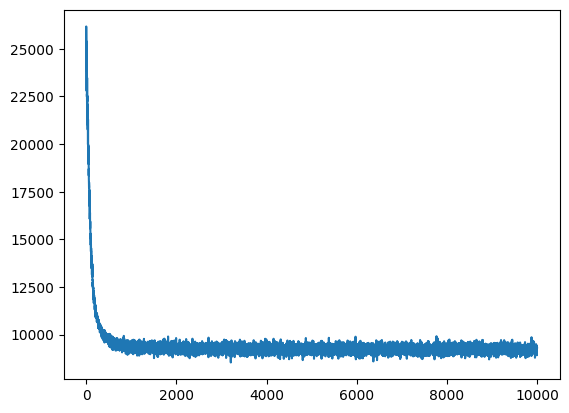

In [8]:
plt.figure()
plt.plot(model_fs.losses)
plt.show()

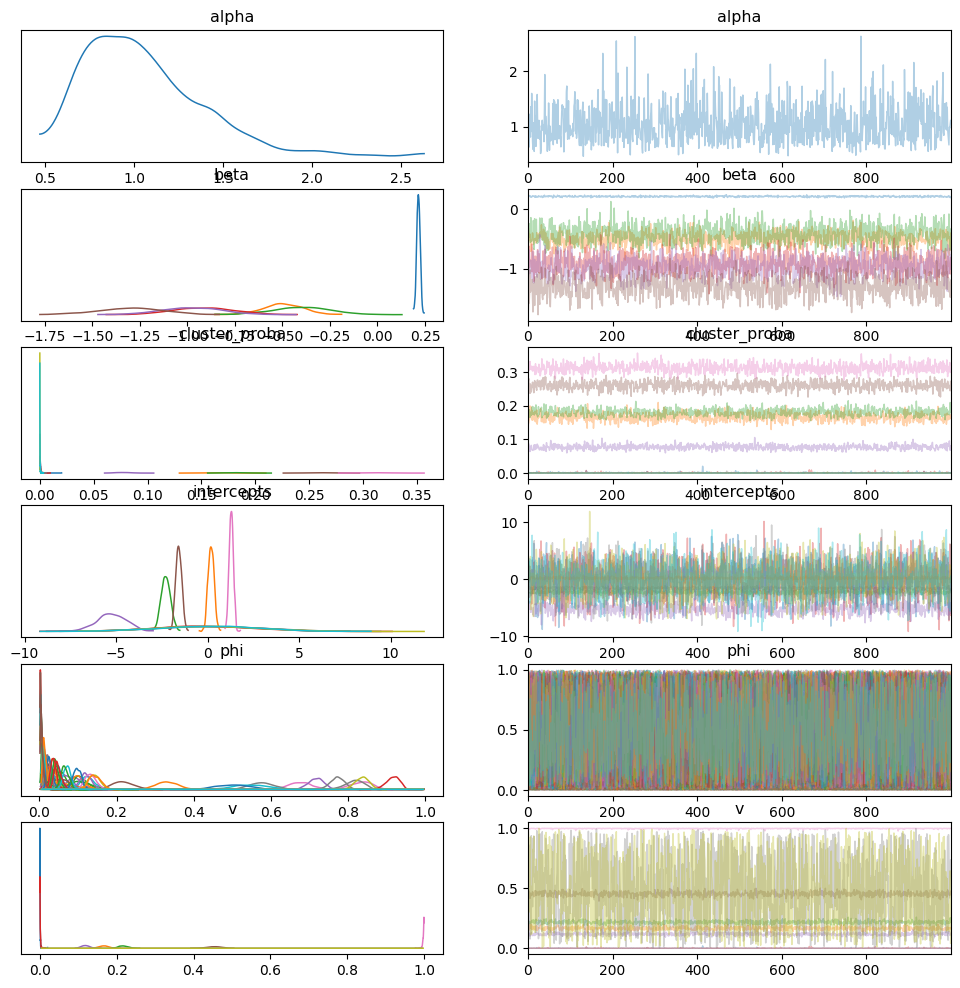

In [9]:
fig=az.plot_trace(model_fs.result)

In [10]:
model_fs.summary(var_names=["beta", "cluster_proba"])

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
r_var_0,0.216,0.009,0.199,0.234,0.000,0.000,989.0,932.0,NaN
r_var_1,-0.497,0.104,-0.695,-0.292,0.004,0.003,691.0,827.0,NaN
r_var_2,-0.400,0.151,-0.700,-0.128,0.005,0.004,934.0,937.0,NaN
r_var_3,-0.913,0.159,-1.223,-0.617,0.005,0.004,1047.0,952.0,NaN
r_var_4,-0.979,0.156,-1.261,-0.657,0.005,0.004,903.0,943.0,NaN
r_var_5,-1.299,0.167,-1.631,-0.986,0.006,0.004,852.0,1029.0,NaN
cluster_proba[0],0.001,0.001,0.000,0.002,0.000,0.000,975.0,865.0,NaN
cluster_proba[1],0.166,0.012,0.144,0.188,0.000,0.000,1071.0,856.0,NaN
cluster_proba[2],0.181,0.010,0.161,0.200,0.000,0.000,985.0,981.0,NaN
cluster_proba[3],0.001,0.001,0.000,0.002,0.000,0.000,1094.0,862.0,NaN


## NUTS

In [11]:
model_n = brm.ProfileRegressionModel()
model_n.fit(
    df[[i for i in df.keys() if i.startswith("d_var")]],
    df[[i for i in df.keys() if i.startswith("r_var")]],
    df["outcome"].astype(int).to_list(),
    method="NUTS",
    warmup=1000,
    samples=1000
)

Found binary response. Using Bernoulli distribution and logit link


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/arviz/data/inference_data.py:1538: UserWarning: The group posterior_individual_level is not defined in the InferenceData scheme
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/arviz/data/inference_data.py:1549: UserWarning: the default dims 'chain' and 'draw' will be added automatically
  warnings.warn(


In [12]:
model_n.summary(var_names=["beta", "cluster_proba"])

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
r_var_0,0.213,0.012,0.192,0.239,0.000,0.000,4439.0,2995.0,1.00
r_var_1,-0.444,0.144,-0.725,-0.163,0.002,0.002,3885.0,3043.0,1.00
r_var_2,-0.395,0.225,-0.863,0.010,0.005,0.003,2084.0,2928.0,1.00
r_var_3,-0.866,0.221,-1.295,-0.437,0.005,0.003,2033.0,2497.0,1.00
r_var_4,-0.927,0.222,-1.354,-0.492,0.005,0.003,2046.0,2982.0,1.00
r_var_5,-1.288,0.228,-1.731,-0.847,0.005,0.004,2021.0,2771.0,1.00
cluster_proba[0],0.180,0.021,0.140,0.219,0.001,0.000,1387.0,1800.0,1.01
cluster_proba[1],0.312,0.017,0.280,0.345,0.000,0.000,1781.0,1947.0,1.00
cluster_proba[2],0.261,0.018,0.224,0.294,0.000,0.000,1911.0,2584.0,1.00
cluster_proba[3],0.169,0.019,0.132,0.204,0.000,0.000,1630.0,2342.0,1.01


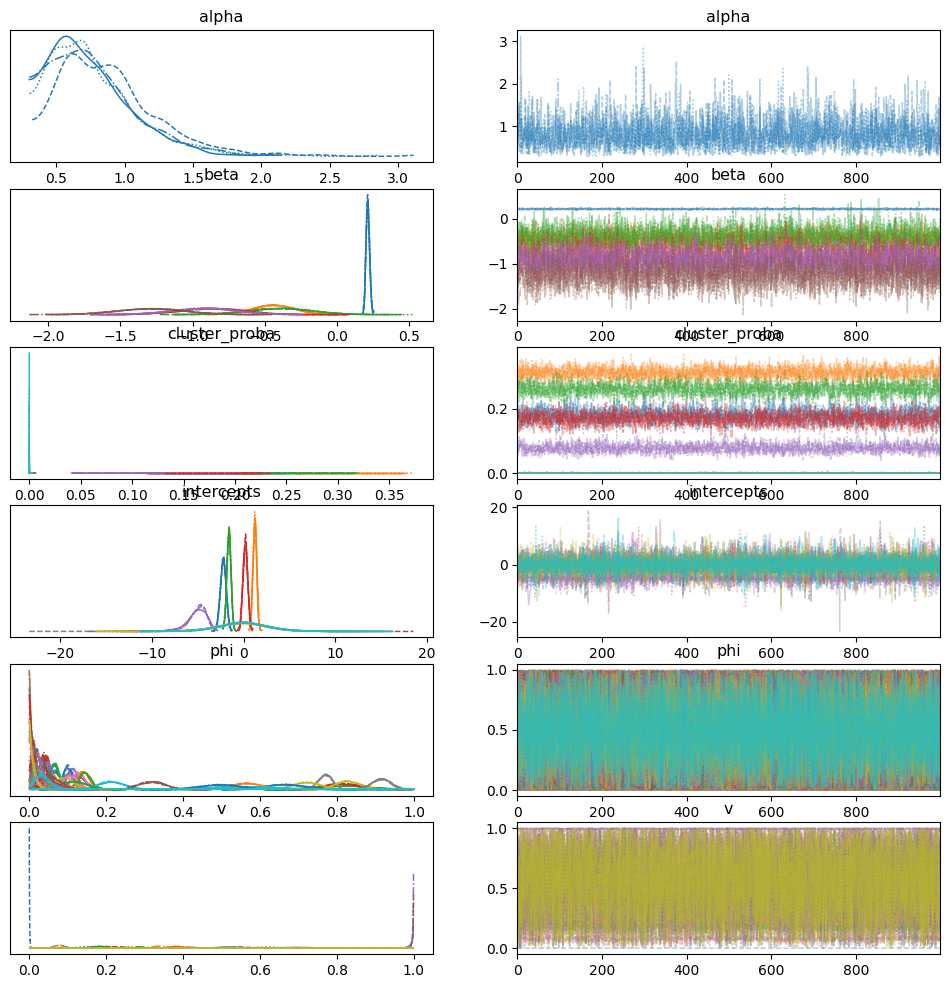

In [13]:
fig = az.plot_trace(model_n.result)